In [130]:
# data
from sklearn.datasets import fetch_openml
import numpy as np
import random
from sklearn.preprocessing import StandardScaler

# models
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# model validation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

# visualisation
import matplotlib
import matplotlib.pyplot as plt

# fine-tuning
from sklearn.model_selection import GridSearchCV

# better print
from IPython.display import display


In [2]:
# Getting the data 
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

# ordering the dataset as explained in here: https://github.com/ageron/handson-ml/issues/301#issuecomment-448853256


def sort_by_target(mnist):
    reorder_train = np.array(
        sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(
        sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]


# fetch_openml() returns targets as strings
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)  # fetch_openml() returns an unsorted dataset

# Split into data and labels
X, y = mnist['data'], mnist['target']

# shuffling the data 
shuffle_index = np.random.permutation(70000)
X, y = X[shuffle_index], y[shuffle_index]

# splitting the data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


In [4]:
# Now, we're going to use the SGD model to classify all 10 numbers at once.
# As the SGD classifier is a linear classifier, scikit learn will know to perform
# a OvA (one-versus-all) strategy.
# That menas that it will train one SGD model to classify each number separately

sgd_class = SGDClassifier(random_state=42)
sgd_class.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [33]:
# Verifying the prediction by passing a random number image

def prediction_print(model):
    rand = random.randint(0, 10000)
    X_example = X_train[rand]
    y_example = y_train[rand]

    %matplotlib inline
    plt.imshow(X_example.reshape(28,28), cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis('off')

    # score_example = sgd_class.decision_function([X_example])
    prediction_example = model.predict([X_example])

    print(f'Predicted: {prediction_example}')

# prediction_print(sgd_class)

In [6]:
# We can also train the Random Forest model.
# This time no OvA/OvO will be needed as the model itself is capable of multinomial classification

forest_class = RandomForestClassifier(random_state=42)
forest_class.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Predicted: [8]


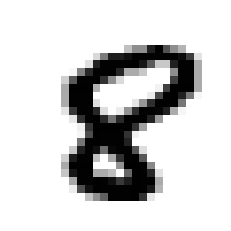

In [8]:
# Visualising thge prediction

prediction_print(forest_class)

In [9]:
# We can additionally see the list of probabilities of the rf model

# In this case the model is 100% sure that the digit ion the picture is a 7
forest_class.predict_proba([X_train[36000]])

array([[0.  , 0.  , 0.  , 0.  , 0.97, 0.  , 0.  , 0.  , 0.01, 0.02]])

## Model Validations

In [10]:
# Evaluating the SDG model by cross validation with accuracy as the score
sdg_accuracy = cross_val_score(sgd_class, X_train, y_train, cv=3, scoring='accuracy')

In [11]:
# Evaluating the SDG model using standardised trauining data.
# This will most likely improve the accuracy score of the model as all the features of 
# each datapoint will be standardised

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_class, X_train_scaled, y_train, cv=3, scoring='accuracy')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([0.90505, 0.90325, 0.8981 ])

## Error analysis

In [12]:
# In order to detect the flaws of the system, we could look at the confusion matrix
# and verify where the model is making the most mistakes
y_train_pred = cross_val_predict(sgd_class, X_train_scaled, y_train)
sdg_conf_mtx = confusion_matrix(y_train, y_train_pred)

sdg_conf_mtx

array([[5578,    0,   20,    7,    8,   33,   33,    5,  216,    0],
       [   0, 6435,   39,   15,    3,   44,    7,    9,  196,   10],
       [  18,   25, 5231,   77,   66,   26,   67,   43,  371,   13],
       [  26,   15,  113, 5253,    1,  195,   22,   43,  398,   59],
       [   8,   13,   44,    9, 5275,    9,   25,   24,  337,  155],
       [  20,   15,   28,  165,   53, 4426,   83,   15,  536,   64],
       [  29,   20,   48,    1,   45,   93, 5527,    6,  143,    0],
       [  20,   10,   60,   19,   49,   14,    4, 5672,  186,  201],
       [  17,   54,   44,   83,    6,  130,   30,    9, 5452,   39],
       [  21,   17,   21,   70,  116,   39,    1,  175,  380, 5125]])

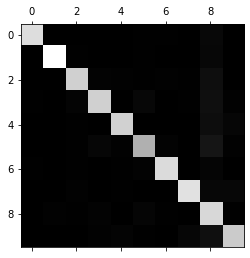

In [13]:
# It's more visible on a graph showing the scale of the confusion.
# Each row represents a class and each column represents the prediction.

plt.matshow(sdg_conf_mtx, cmap=plt.cm.gray)
plt.show()

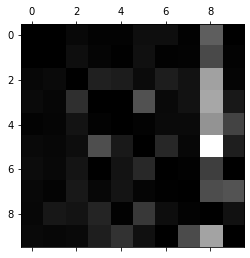

In [14]:
# In order to get a more normalised view of the matrix, we can devide each row
# by the number of datapoints in that class.
cat_sums = sdg_conf_mtx.sum(axis=1, keepdims=True)
norm_sdg_conf_mtx = sdg_conf_mtx / cat_sums

# Now, lets fill the diagonal with 0's as the correct predictions do nopt concern us.
np.fill_diagonal(norm_sdg_conf_mtx, 0)

# and display
plt.matshow(norm_sdg_conf_mtx, cmap=plt.cm.gray)
plt.show()

# We can see immediatelly that nearly all of the numbers are being confused with 8's
# Most notably 0,2,3,4,5 and 9 from which 5 is very bad

In [15]:
# You can see here that 8's are not the smalles class in the dataset
np.unique(y_train, return_counts=True)[1]

array([5900, 6758, 5937, 6125, 5899, 5405, 5912, 6235, 5864, 5965])

In [ ]:
# Lastly, it would be a good idea to analise the individual errors.
# However, I'm not going to include that in this notebook

## Multilabel Classification

In [74]:
# A multilabel classification model would be used in order to determine more than one class out of each datapoint
# For example, let's say that each picture could contain faces of three people: Alice, Bob and Chartlie
# Then if presented with a phot of Alice and Bob, the model sghouel return [1,1,0]
# (As in Alice- yes, Bob - yes, Charlie - no)

# A more realistic example would be if we'd want to recognise if a number is or isn't
# larger than 6 and is or isn't an odd number
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

# We will use a KNN classifier as it is able to work with multilabel datasets
knn_class = KNeighborsClassifier()
knn_class.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [96]:
# verifying the models prediction on a random datapoint
r = random.randint(0, 60000)
X_rand = X_train[r]
print(y_train[r])

knn_class.predict([X_rand])

7.0


array([[ True,  True]])

In [ ]:
# Evaluating a multilabel classification model
y_train_knn_pred = cross_val_predict(knn_class, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

## Trying to achieve 97% accuracy on MNIST

In [5]:
# First, trying the KNC model
knn = KNeighborsClassifier()

# GridSearch fine-tuning
# try to tweak some more hyperparameters that are not there yet
params = [
    {'weights': ['distance'], 'n_neighbors': [3, 4, 5]}
]

grid_search = GridSearchCV(knn, params, cv=3, scoring='accuracy', n_jobs=1, verbose=5)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  19.5s
[CV 2/3] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  18.9s
[CV 3/3] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  19.8s
[CV 1/3] END ...n_neighbors=4, weights=distance;, score=0.971 total time=  22.9s
[CV 2/3] END ...n_neighbors=4, weights=distance;, score=0.972 total time=  23.3s
[CV 3/3] END ...n_neighbors=4, weights=distance;, score=0.971 total time=  24.6s
[CV 1/3] END ...n_neighbors=5, weights=distance;, score=0.968 total time=  24.1s
[CV 2/3] END ...n_neighbors=5, weights=distance;, score=0.970 total time=  22.3s
[CV 3/3] END ...n_neighbors=5, weights=distance;, score=0.969 total time=  21.5s


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid=[{'n_neighbors': [3, 4, 5], 'weights': ['distance']}],
             scoring='accuracy', verbose=5)

In [6]:
# Getting the best parameters for that grid search
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [7]:
cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=3, scoring='accuracy')


array([0.97075, 0.97185, 0.971  ])

In [34]:
# hardcoding the best performing model to maximise reusability without re-execution of the cv grid search
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

cross_val_score(knn, X_train,
                y_train, cv=3, scoring='accuracy')



array([0.97075, 0.97185, 0.971  ])

In [35]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

### Generating additional data

In order to improve the accuracy of the model, we can generate 
artificial data by slightly altering the existing one.

We'll do it by shifting the position of each number by one in each direction.
This way, we'll create a dataset that is 4 times larger than the original one. 

In [37]:
def print_number(number):
    %matplotlib inline
    plt.imshow(number.reshape(28, 28), cmap=matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis('off')


Predicted: [7]


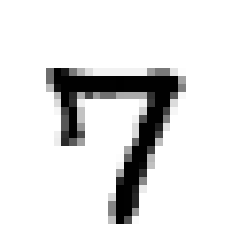

In [36]:
prediction_print(knn)

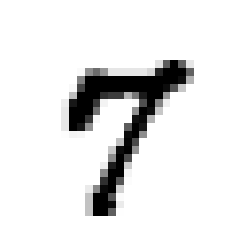

In [38]:
example = X_train[0, :] #first number

print_number(example)


In [63]:
example[]

0.0

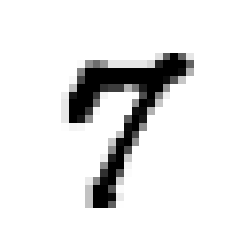

In [56]:
first_line = example.reshape(28,28)[:1]
rest = example.reshape(28, 28)[1:]

shifted = np.concatenate((rest, first_line))
shifted.shape

print_number(shifted) #image shifted upwards


In [60]:
np.array_equal(shifted.reshape(28*28), shifted.flatten())


True

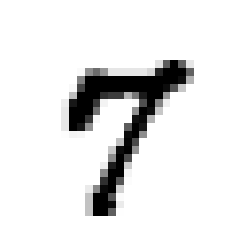

In [96]:
print_number(example)

In [106]:
def shift_image(image, by=1):
    image = image.reshape(28,28)

    up = np.concatenate((image[by:], image[:by])).flatten()
    down = np.concatenate((image[-by:], image[:-by])).flatten()
    left = np.concatenate((image[:, by:], image[:, :by]), axis=1).flatten()
    right = np.concatenate((image[:, -by:], image[:, :-by]), axis=1).flatten()
    
    return up, down, left, right


In [141]:
shift_image(example)[0]


array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [131]:
from time import sleep

print('Test 1')
dh = display('Test2', display_id=True)
sleep(1)
dh.update('Test3')


Test 1


'Test3'

In [135]:
X_train_shifted = X_train
y_train_shifted = y_train

dh = display('', display_id=True)

for n, (image, label) in enumerate(zip(X_train, y_train)):
   X_train_shifted = np.concatenate((X_train_shifted,shift_image(image)))
   y_train = np.concatenate((y_train, np.full(4, label))) # have to add four labels for all four shifted images

   dh.update(f'shifted {round((n+1)/(X_train.shape[0]), 4)}% of images...')


'shifted 0.0157% of images...'

KeyboardInterrupt: 